# I. Data preparation

Loading data from source

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import tensorflow.keras.layers as tfl
import os
import pickle

ImportError: Traceback (most recent call last):
  File "c:\Users\User\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
from zipfile import ZipFile

zip_dir = 'data/emotion_data.zip'
extraction_dir = ""

with ZipFile(zip_dir, 'r') as zip_object:
    zip_object.extractall(path=extraction_dir)

print(f"All files extracted from '{zip_dir}' to '{extraction_dir}'.")

In [ ]:
data_dir = pathlib.Path("emotion_data/")

Viewing training data

In [ ]:
num_train_images = len(list(data_dir.glob("train/*/*")))
print("Images:", num_train_images)
print("Classes:", list(data_dir.glob("train/*")))

Images: 28709
Classes: [WindowsPath('emotion_data/train/angry'), WindowsPath('emotion_data/train/disgust'), WindowsPath('emotion_data/train/fear'), WindowsPath('emotion_data/train/happy'), WindowsPath('emotion_data/train/neutral'), WindowsPath('emotion_data/train/sad'), WindowsPath('emotion_data/train/surprise')]


Viewing the images

emotion_data\train\angry


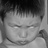

In [ ]:
path = list(data_dir.glob("train/*"))[0]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

emotion_data\train\disgust


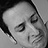

In [ ]:
path = list(data_dir.glob("train/*"))[1]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

Loading the dataset

In [ ]:
train_dir = pathlib.Path("emotion_data/train")

batch_size = 64
# img_height = 180
# img_width = 180
val_split = 0.2

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="both",
    seed=91,
    image_size=(48,48),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True
)
# train_ds = train_ds.shuffle(buffer_size=len(list(train_ds.as_numpy_iterator())))
# val_ds = val_ds.shuffle(buffer_size=len(list(val_ds.as_numpy_iterator())))

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


Viewing some batches

In [ ]:
b = 3
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print("Max:", np.max(image_batch.numpy()))
    print("Min:", np.min(image_batch.numpy()))
    print("Labels:", np.unique(labels_batch.numpy()))
    print()
    b-=1
    if b<=0:
        break

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 2 3 4 5 6]

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 1 2 3 4 5 6]

(64, 48, 48, 1)
(64,)
Max: 255.0
Min: 0.0
Labels: [0 2 3 4 5 6]



## Training preparation

In [ ]:
class_names = train_ds.class_names
image_shape = None
labels_shape = None
num_classes = len(class_names)

for image_batch, labels_batch in train_ds:
    image_shape = image_batch.shape[1:]
    labels_shape = labels_batch.numpy().reshape(-1, 1).shape[1:]
    break

print(class_names, image_shape, labels_shape)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] (48, 48, 1) (1,)


Dataset configuration

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

subset_reduction_factor_train = 0.2
subset_reduction_factor_val = 0.2
num_batches = num_train_images//batch_size

train_subset_size = int(num_batches*(1-val_split)*subset_reduction_factor_train)
val_subset_size = int(num_batches*val_split*subset_reduction_factor_val)

used_train_ds = train_ds.cache().take(train_subset_size).prefetch(buffer_size=AUTOTUNE)
used_val_ds = val_ds.cache().take(val_subset_size).prefetch(buffer_size=AUTOTUNE)

train_subset_size, val_subset_size

(71, 17)

Viewing training and validation data to ensure similar representations

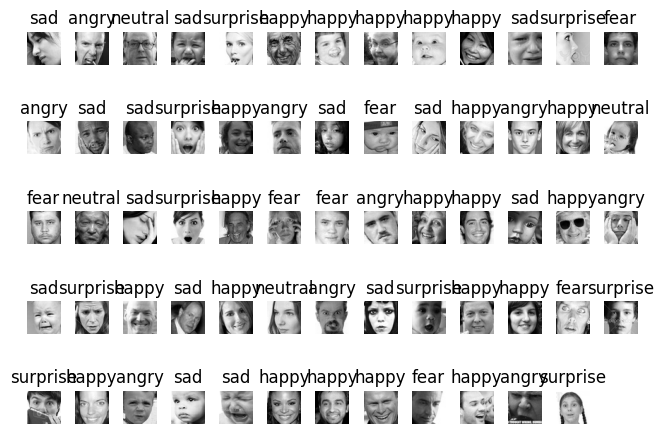

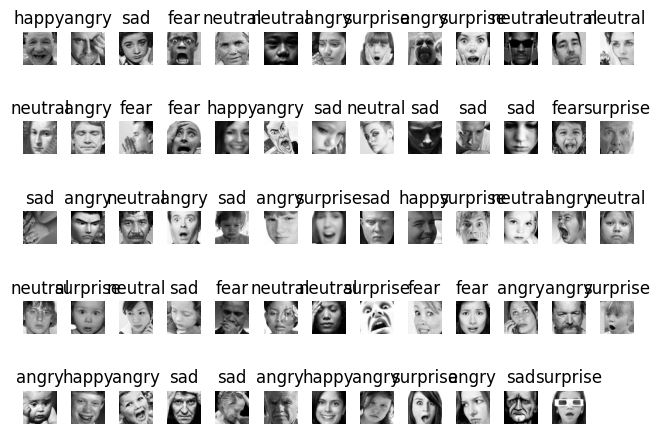

In [ ]:
def view_batch(ds, batch_num):
    c = 0
    for image_batch, labels_batch in ds:
        if batch_num != c:
            c+=1
            continue
        # print(image_batch.shape[0], int(np.ceil(image_batch.shape[0]/5)))
        for index, image in enumerate(image_batch):
            label = labels_batch[index]
            ax = plt.subplot(5, int(np.ceil(image_batch.shape[0]/5)), index+1)
            ax.imshow(image.numpy().astype("uint8"), cmap="gray")
            ax.axis("off")
            ax.set_title(class_names[label.numpy()])
        break
    plt.tight_layout()
    plt.show()

def view_batch_shape(ds):
    for i, j in ds:
        print(i.shape, j.shape)
        break

view_batch(used_train_ds, 1)
view_batch(used_val_ds, 1)

# 2. Training

## Utilities

### Save/load utilities

Every time a distinct model is trained and/or used for observations, call `set_save_paths(model_name: str)`. Use the paths `checkpoint_path` and `base_path`, as well as the subroutines below, accordingly.

Information that can be saved and loaded are the training history and the parameters of a model.

By default, models load pretrained weights. Cells containing `model.fit()` can be optionally run once or multiple times by changing the cell format from raw to Python.

To train a fresh model, delete/rename the `training` folder (or its specific subfolders)

In [ ]:
base_path:str = None
checkpoint_path:str = None
current_model_name:str = None

In [ ]:
def create_path(filepath, isfile=True):
    path = pathlib.Path(filepath)
    if isfile:
        path.parent.mkdir(parents=True, exist_ok=True)
        path.touch(exist_ok=True)
    else:
        path.mkdir(parents=True, exist_ok=True)

def set_save_paths(model_name:tf.keras.Model):
    global checkpoint_path
    global base_path
    global current_model_name
    current_model_name = model_name
    base_path = f"training/{model_name}"
    checkpoint_path = f"{base_path}/parameters.weights.h5"
    print("Save path now belongs to", current_model_name)

def load_parameters(model, custom_model_name=None):
    global checkpoint_path
    global base_path
    global current_model_name

    used_model_name = custom_model_name if custom_model_name != None else current_model_name
    used_checkpoint_path = f"training/{used_model_name}/parameters.weights.h5"

    print("Loading parameters of", used_model_name, f"({'Custom' if custom_model_name != None else 'Default'})")

    if not os.path.isfile(used_checkpoint_path):
        print("No parameters found, no parameters loaded from", used_model_name)
        return

    model.load_weights(used_checkpoint_path, skip_mismatch=True)

def save_object(object, name="history"):
    global checkpoint_path
    global base_path
    global current_model_name

    path = f"{base_path}/{name}"

    create_path(path, isfile=False)

    all_items = os.listdir(path)
    files_only = [os.path.join(path, item) for item in all_items]
    files_only = [item for item in files_only if os.path.isfile(item)]
    
    filepath = f"{path}/{len(files_only)}.pickle"
    create_path(filepath)
    
    print(f"Saving {name} of", current_model_name)
    with open(filepath, 'wb') as f:
        pickle.dump(object.history if name=="history" else object, f)

def load_object(name="history"):
    global checkpoint_path
    global base_path
    global current_model_name
    
    path = f"{base_path}//{name}"

    print(f"Loading {name} of", current_model_name)
    histories = []
    for i in os.listdir(path):
        path = os.path.join(path, i)
        if not os.path.isfile(path):
            continue
        with open(path, 'rb') as f:
            histories.append(pickle.load(f))
        
    return histories

def plot_object(chosen_attributes, ylim1=0, ylim2=1, name="history"):
    objects = load_object(name)
    for i in chosen_attributes:
        attribute_list = [item for cur_object in objects for item in cur_object[i]]
        plt.plot(np.arange(len(attribute_list)), attribute_list, label=i)
    plt.legend()
    plt.ylim(ylim1, ylim2)
    plt.title(f"{name} of {current_model_name}")
    plt.show()

## Model approaches

### Standard approach

In [ ]:
set_save_paths("standard_model")

model = tf.keras.models.Sequential([
    tfl.Rescaling(1/255, input_shape=image_shape),
    tfl.Conv2D(16, 3, padding='same', activation='relu', name="conv1"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(32, 3, padding='same', activation='relu', name="conv2"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(64, 3, padding='same', activation='relu', name="conv3"),
    tfl.AveragePooling2D(3),
    tfl.Flatten(),
    tfl.Dense(128, activation='relu', name="dense1"),
    tfl.Dense(num_classes, name="dense2")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

load_parameters(model)
model.summary()

Save path now belongs to standard_model
Loading parameters of standard_model (Default)
No parameters found, no parameters loaded from standard_model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 4, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,399 (607.03 KB)

 Trainable params: 155,399 (607.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
load_parameters(model)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds,
    epochs=20,
    callbacks=[cp_callback]
)

save_object(history)

Loading parameters of standard_model (Default)
No parameters found, no parameters loaded from standard_model
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2334 - loss: 1.8582 - val_accuracy: 0.2675 - val_loss: 1.7955
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2383 - loss: 1.8152 - val_accuracy: 0.2675 - val_loss: 1.7589
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.2923 - loss: 1.7551 - val_accuracy: 0.3235 - val_loss: 1.6931
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3314 - loss: 1.6895 - val_accuracy: 0.3787 - val_loss: 1.6035
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3722 - loss: 1.6274 - val_accuracy: 0.3842 - val_loss: 1.5676
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3854 - loss: 1.5838 - val_accuracy: 0.4090 - val_loss: 1.5357
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4122 - loss: 1.5589 - val_accuracy: 0.4154 - val_loss: 1.5182
Ep

Loading history of standard_model


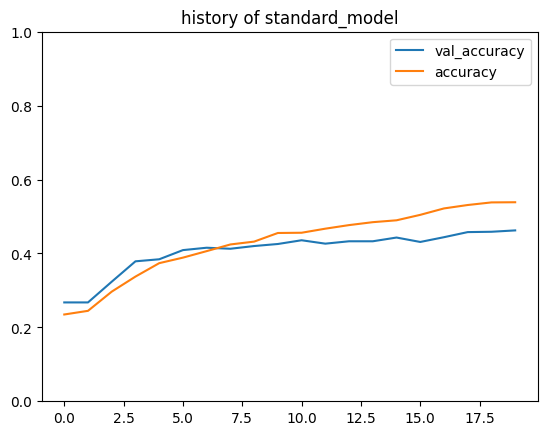

In [ ]:
plot_object(["val_accuracy", "accuracy"])

Problems include slow learning and overfitting. The next approach addresses the latter.

### Augmentation utility

In [ ]:
augmentation = tf.keras.models.Sequential([
    tfl.RandomFlip("horizontal", input_shape=image_shape),
    tfl.RandomRotation(0.05),
    tfl.RandomZoom(height_factor=(-0.1, 0), fill_mode="constant", fill_value=0),
])

c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Data augmentation

In [ ]:
# Taking one batch, applying the augmentation on that same batch multiple times, and then showing variations of a specific picture in that batch
image_in_batch = 1
for images, _ in used_train_ds:
    for i in range(9):
        augmented_images = augmentation(images) # augmentation alters image randomly every time
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[image_in_batch].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
    break
plt.tight_layout()
plt.show()
view_batch(used_train_ds, 0)

NameError: name 'augmentation' is not defined

Seems like the augmentation is pretty reasonable

In [ ]:
set_save_paths("augmentation_model")

model = tf.keras.models.Sequential([
    augmentation,
    tfl.Rescaling(1/255, input_shape=image_shape),
    tfl.Conv2D(16, 3, padding='same', activation='relu', name="conv1"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(32, 3, padding='same', activation='relu', name="conv2"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(64, 3, padding='same', activation='relu', name="conv3"),
    tfl.MaxPooling2D(2),
    tfl.Conv2D(64, 3, padding='same', activation='relu', name="conv4"),
    tfl.AveragePooling2D(3),
    tfl.Flatten(),
    tfl.Dense(128, activation='relu', name="dense1"),
    tfl.Dense(num_classes, name="dense2")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

load_parameters(model)
model.summary()

Save path now belongs to augmentation_model
Loading parameters of augmentation_model (Default)


c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 2, 2, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,023 (367.28 KB)

 Trainable params: 94,023 (367.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
load_parameters(model)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds,
    epochs=20,
    callbacks=[cp_callback, es_callback]
)

save_object(history)

Loading parameters of augmentation_model (Default)
Epoch 1/20


71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.4705 - loss: 1.3967 - val_accuracy: 0.4301 - val_loss: 1.4386
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.4646 - loss: 1.3964 - val_accuracy: 0.4485 - val_loss: 1.3988
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.4860 - loss: 1.3697 - val_accuracy: 0.4623 - val_loss: 1.3912
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.4827 - loss: 1.3343 - val_accuracy: 0.4476 - val_loss: 1.3996
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4818 - loss: 1.3601 - val_accuracy: 0.4623 - val_loss: 1.3815
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4777 - loss: 1.3494 - val_accuracy: 0.4494 - val_loss: 1.3757
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4878 - loss: 1.3349 - val_accuracy: 0.4596 - val_loss: 1.3908
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.4859 - loss: 1.3187 - val_accuracy: 0.4632 - val_los

Loading history of augmentation_model


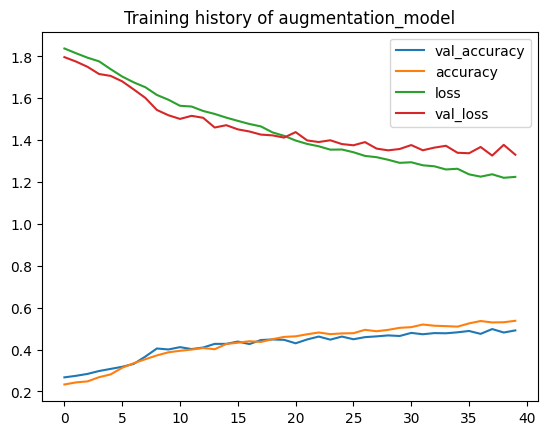

In [ ]:
plot_object(["val_accuracy", "accuracy", "loss", "val_loss"], None, None)

Overfitting is reduced but learning is really slow

### Optimizer adjustments and depthwise separable convolutions 

In [ ]:
optimizers = {
    "sgd": tf.keras.optimizers.SGD(),
    "adam": tf.keras.optimizers.Adam(),
    "rmsprop": tf.keras.optimizers.RMSprop()
}

for i in list(optimizers.keys()):
    set_save_paths(f"{i}_model")

    model = tf.keras.models.Sequential([
        augmentation,
        tfl.Rescaling(1/255, input_shape=image_shape),
        tfl.SeparableConv2D(16, 3, padding='same', activation='relu', name="conv1", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(32, 3, padding='same', activation='relu', name="conv2", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv3", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv4", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.AveragePooling2D(3),
        tfl.Flatten(),
        tfl.Dense(128, activation='relu', name="dense1"),
        tfl.Dense(num_classes, name="dense2")
    ])

    model.compile(
        optimizer=optimizers[i],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    load_parameters(model)
    model.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  # Metric to monitor (e.g., validation loss)
        patience=10,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
    )

    history = model.fit(
        used_train_ds,
        validation_data=used_val_ds,
        epochs=8,
        callbacks=[cp_callback, es_callback]
    )

    save_object(history)

Save path now belongs to sgd_model


c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loading parameters of sgd_model (Default)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (SeparableConv2D)         │ (None, 48, 48, 16)     │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (SeparableConv2D)         │ (None, 24, 24, 32)     │           688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (SeparableConv2D)         │ (None, 12, 12, 64)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (SeparableConv2D)         │ (None, 6, 6, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 2, 2, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,664 (162.75 KB)

 Trainable params: 41,664 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.2446 - loss: 1.8352 - val_accuracy: 0.2675 - val_loss: 1.8138
Epoch 2/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2433 - loss: 1.8335 - val_accuracy: 0.2675 - val_loss: 1.8107
Epoch 3/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2476 - loss: 1.8302 - val_accuracy: 0.2675 - val_loss: 1.8082
Epoch 4/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2441 - loss: 1.8287 - val_accuracy: 0.2675 - val_loss: 1.8058
Epoch 5/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2400 - loss: 1.8312 - val_accuracy: 0.2675 - val_loss: 1.8037
Epoch 6/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2477 - loss: 1.8248 - val_accuracy: 0.2675 - val_loss: 1.8024
Epoch 7/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2450 - loss: 1.8244 - val_accuracy: 0.2675 - val_loss: 1.8011
Epoch 8/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2475 - loss: 1.8230 - val_accuracy: 0.2675 - val_loss:

c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (SeparableConv2D)         │ (None, 48, 48, 16)     │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (SeparableConv2D)         │ (None, 24, 24, 32)     │           688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (SeparableConv2D)         │ (None, 12, 12, 64)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (SeparableConv2D)         │ (None, 6, 6, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 2, 2, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,664 (162.75 KB)

 Trainable params: 41,664 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.2664 - loss: 1.7653 - val_accuracy: 0.2794 - val_loss: 1.7364
Epoch 2/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2736 - loss: 1.7587 - val_accuracy: 0.2803 - val_loss: 1.7296
Epoch 3/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.2768 - loss: 1.7557 - val_accuracy: 0.2914 - val_loss: 1.7205
Epoch 4/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2840 - loss: 1.7533 - val_accuracy: 0.2950 - val_loss: 1.7164
Epoch 5/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2896 - loss: 1.7441 - val_accuracy: 0.2914 - val_loss: 1.7168
Epoch 6/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2925 - loss: 1.7421 - val_accuracy: 0.2858 - val_loss: 1.7115
Epoch 7/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2873 - loss: 1.7415 - val_accuracy: 0.3051 - val_loss: 1.7022
Epoch 8/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2962 - loss: 1.7252 - val_accuracy: 0.3051 - val_loss

c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (SeparableConv2D)         │ (None, 48, 48, 16)     │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (SeparableConv2D)         │ (None, 24, 24, 32)     │           688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (SeparableConv2D)         │ (None, 12, 12, 64)     │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (SeparableConv2D)         │ (None, 6, 6, 64)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 2, 2, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,664 (162.75 KB)

 Trainable params: 41,664 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.2442 - loss: 1.8046 - val_accuracy: 0.2656 - val_loss: 1.7698
Epoch 2/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2493 - loss: 1.7951 - val_accuracy: 0.2693 - val_loss: 1.7727
Epoch 3/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2436 - loss: 1.7995 - val_accuracy: 0.2684 - val_loss: 1.7715
Epoch 4/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2560 - loss: 1.7942 - val_accuracy: 0.2721 - val_loss: 1.7670
Epoch 5/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.2509 - loss: 1.7926 - val_accuracy: 0.2583 - val_loss: 1.7691
Epoch 6/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2629 - loss: 1.7819 - val_accuracy: 0.2684 - val_loss: 1.7620
Epoch 7/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2561 - loss: 1.7916 - val_accuracy: 0.2693 - val_loss: 1.7596
Epoch 8/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2455 - loss: 1.7914 - val_accuracy: 0.2702 - val_loss:

Save path now belongs to sgd_model
Loading history of sgd_model


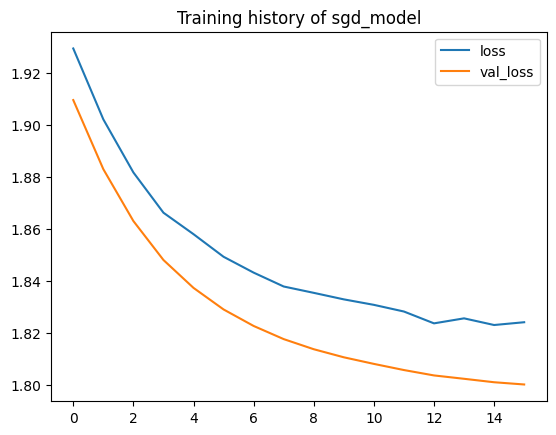

Save path now belongs to adam_model
Loading history of adam_model


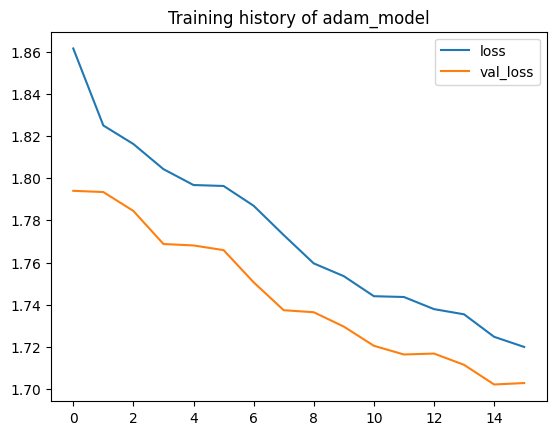

Save path now belongs to rmsprop_model
Loading history of rmsprop_model


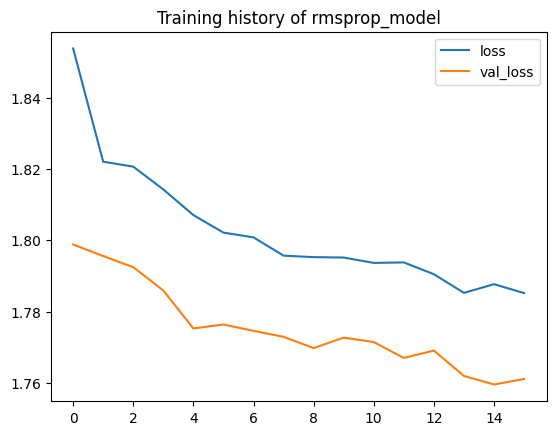

In [ ]:
for i in ["sgd", "adam", "rmsprop"]:
    set_save_paths(f"{i}_model")
    plot_object(["loss", "val_loss"], None, None)

Adam has the best optimization, no adjustment needed.

### Learning rate adjustments and learning rate schedulers

In [ ]:
schedulers = {
    "cosine": tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.01,
        decay_steps=1000,
        alpha=0.0001,
        name='CosineDecay',
    ),
    "cosine_restarts": tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=0.01,
        first_decay_steps=500,
        t_mul=2.0,
        m_mul=1.0,
        alpha=0.0001,
    ),
    "none": 0.001,
    "high": 0.01,
    "exponential": tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=100,
        decay_rate=0.95,
        staircase=False
    )
}

# class LRTensorBoard(Callback):
#     def __init__(self, log_dir):
#         super().__init__()
#         self.file_writer = tf.summary.create_file_writer(log_dir)

#     def on_epoch_end(self, epoch, logs=None):
#         # This will log the learning rate at the end of each epoch
#         with self.file_writer.as_default():
#             tf.summary.scalar('learning_rate', self.model.optimizer.lr(self.model.optimizer.iterations), step=epoch)

#     def on_batch_end(self, batch, logs=None):
#         # This will log the learning rate at the end of each batch
#         with self.file_writer.as_default():
#             tf.summary.scalar('learning_rate_per_batch', self.model.optimizer.lr(self.model.optimizer.iterations), step=self.model.optimizer.iterations)

for i in list(schedulers.keys()):
    set_save_paths(f"lr_{i}_model")

    model = tf.keras.models.Sequential([
        augmentation,
        tfl.Rescaling(1/255, input_shape=image_shape),
        tfl.SeparableConv2D(16, 3, padding='same', activation='relu', name="conv1", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(32, 3, padding='same', activation='relu', name="conv2", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv3", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.MaxPooling2D(2),
        tfl.SeparableConv2D(64, 3, padding='same', activation='relu', name="conv4", depthwise_initializer=tf.keras.initializers.glorot_uniform(), pointwise_initializer=tf.keras.initializers.glorot_uniform()),
        tfl.AveragePooling2D(3),
        tfl.Flatten(),
        tfl.Dense(128, activation='relu', name="dense1"),
        tfl.Dense(num_classes, name="dense2")
    ])

    optimizer_used = tf.keras.optimizers.Adam(learning_rate=schedulers[i])
    model.compile(
        optimizer=optimizer_used,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    load_parameters(model)
    # model.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  # Metric to monitor (e.g., validation loss)
        patience=10,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
    )

    lr_tracker = {
        "lr": []
    }

    # additionally, we are creating a callback to track the lr
    def on_epoch_end_callback(epoch, logs):
        current_lr = None
        if isinstance(optimizer_used.learning_rate, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = optimizer_used.learning_rate(optimizer_used.iterations)
        else:
            current_lr = optimizer_used.learning_rate # If it's a fixed learning rate
        lr_tracker["lr"].append(current_lr.numpy())

    # Create a LambdaCallback instance
    epoch_end_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end_callback)

    history = model.fit(
        used_train_ds,
        validation_data=used_val_ds,
        epochs=20,
        callbacks=[cp_callback, es_callback, epoch_end_callback],
        verbose=1
    )

    save_object(history)
    save_object(lr_tracker, name="lr")

Save path now belongs to lr_cosine_model
Loading parameters of lr_cosine_model (Default)
No parameters found, no parameters loaded from lr_cosine_model
Epoch 1/20


c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2240 - loss: 1.8538 - val_accuracy: 0.2675 - val_loss: 1.7997
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2448 - loss: 1.8275 - val_accuracy: 0.2675 - val_loss: 1.7960
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2414 - loss: 1.8257 - val_accuracy: 0.2675 - val_loss: 1.7930
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2431 - loss: 1.8238 - val_accuracy: 0.2675 - val_loss: 1.7979
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2480 - loss: 1.8237 - val_accuracy: 0.2675 - val_loss: 1.7956
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2433 - loss: 1.8291 - val_accuracy: 0.2675 - val_loss: 1.7937
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2477 - loss: 1.8195 - val_accuracy: 0.2675 - val_loss: 1.7954
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2418 - loss: 1.8209 - val_accuracy: 0.2675 - val_loss: 1.

Save path now belongs to lr_cosine_model
Loading lr of lr_cosine_model


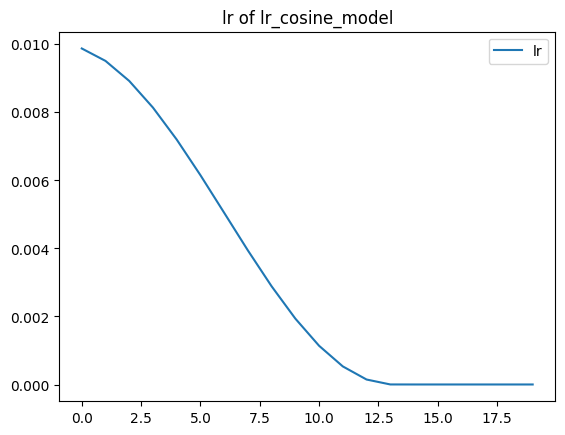

Save path now belongs to lr_cosine_restarts_model
Loading lr of lr_cosine_restarts_model


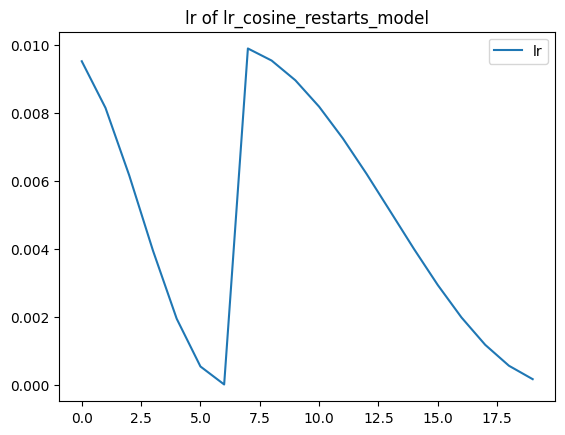

Save path now belongs to lr_none_model
Loading lr of lr_none_model


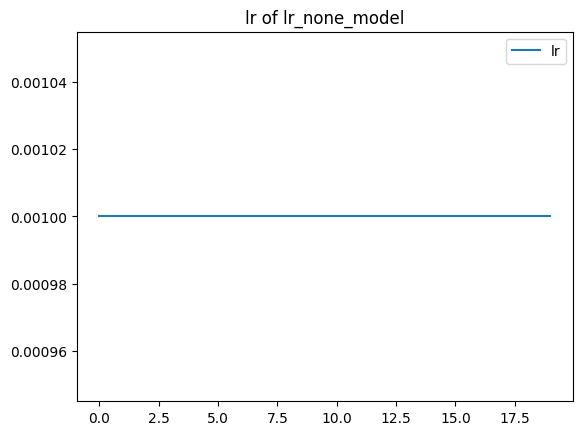

Save path now belongs to lr_high_model
Loading lr of lr_high_model


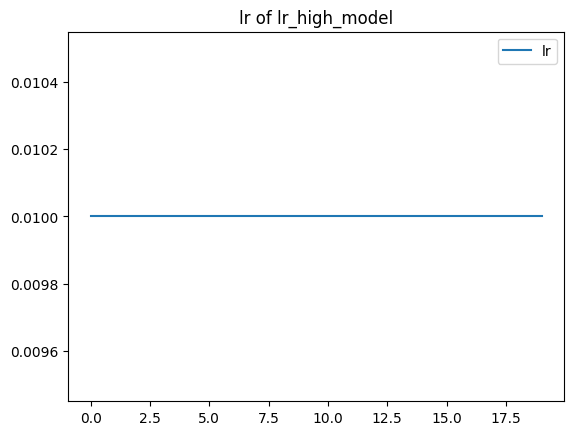

Save path now belongs to lr_exponential_model
Loading lr of lr_exponential_model


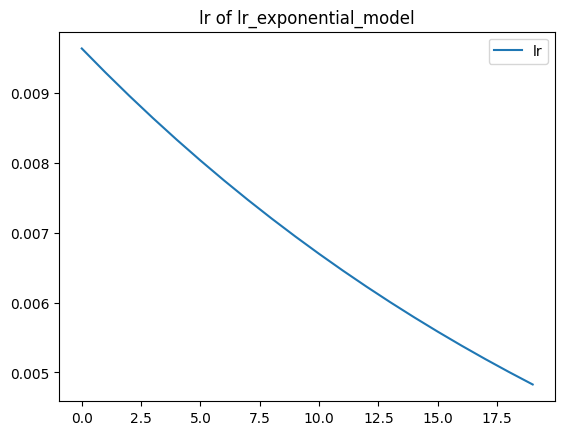

In [ ]:
for i in list(schedulers.keys()):
    set_save_paths(f"lr_{i}_model")
    plot_object(["lr"], None, None, name="lr")

Save path now belongs to lr_cosine_model
Loading history of lr_cosine_model


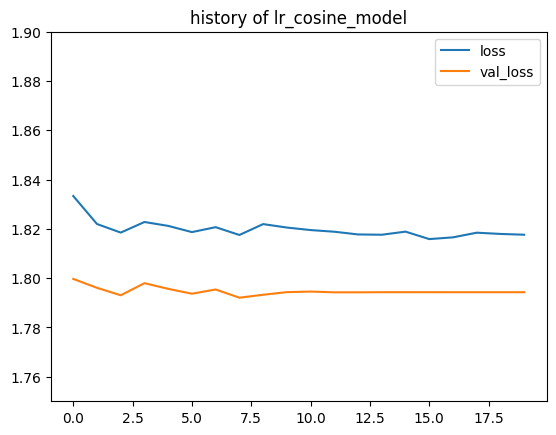

Save path now belongs to lr_cosine_restarts_model
Loading history of lr_cosine_restarts_model


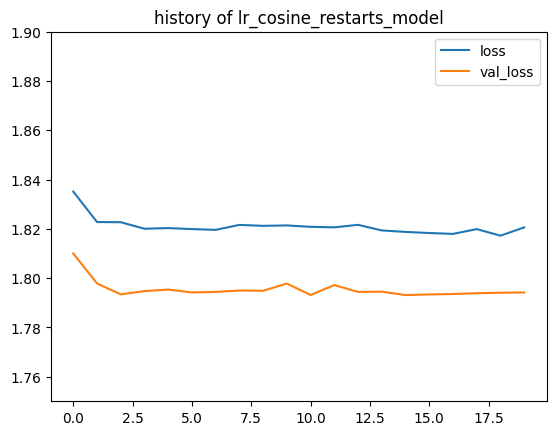

Save path now belongs to lr_none_model
Loading history of lr_none_model


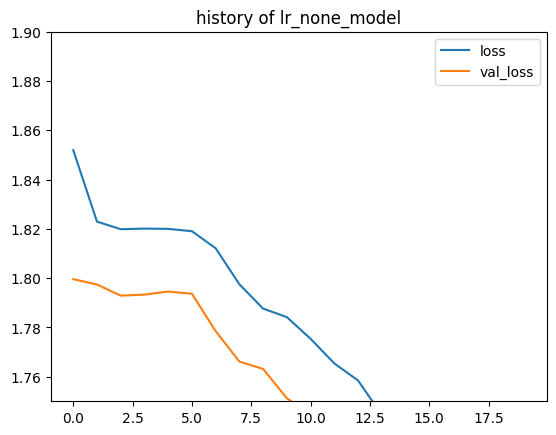

Save path now belongs to lr_high_model
Loading history of lr_high_model


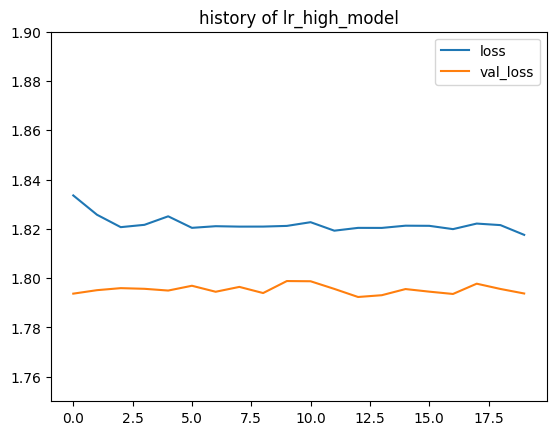

Save path now belongs to lr_exponential_model
Loading history of lr_exponential_model


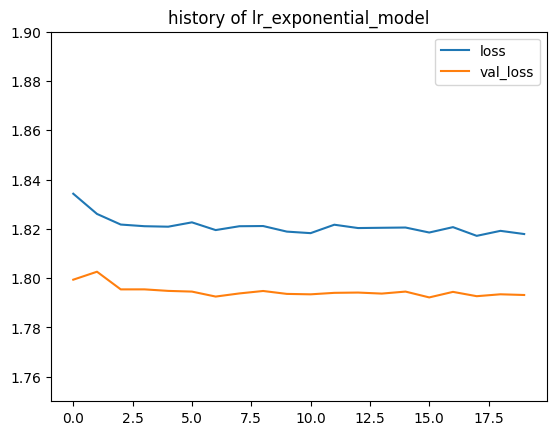

In [ ]:
for i in list(schedulers.keys()):
    set_save_paths(f"lr_{i}_model")
    plot_object(["loss", "val_loss"], 1.75, 1.9)